# Efficient posterior profiles

Shivam Pandey (), Cyrille Doux (<doux@lpsc.in2p3.fr>), Marco Raveri (<marco.raveri@unige.it>)

In this notebook we show how to obtain posterior profiles from synthetic probability models, as in [Pandey, Doux and Raveri (2024), arXiv:XXXX.XXXX](https://arxiv.org/abs/XXXX.XXXXX).

If you want more details on how to build normalizing flow based synthetic models for posterior distributions check out the corresponding example notebook.

## Notebook setup:

We start by importing everything and setting up a controlled example:

In [1]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# tensorflow imports:
import tensorflow as tf
import tensorflow_probability as tfp

# import the tensiometer tools that we need:
import tensiometer
from tensiometer import utilities
from tensiometer import synthetic_probability

# getdist settings to ensure consistency of plots:
getdist_settings = {'ignore_rows': 0.0, 
                    'smooth_scale_2D': 0.3,
                    'smooth_scale_1D': 0.3,
                    }    

2024-07-18 08:37:43.649174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We build here a random Gaussian mixture model that we are going to use for tests.

The esample is seeded so that it is reproducible. If you want a different example change the value of the seed.

You can also change dimensionality and number of modes.

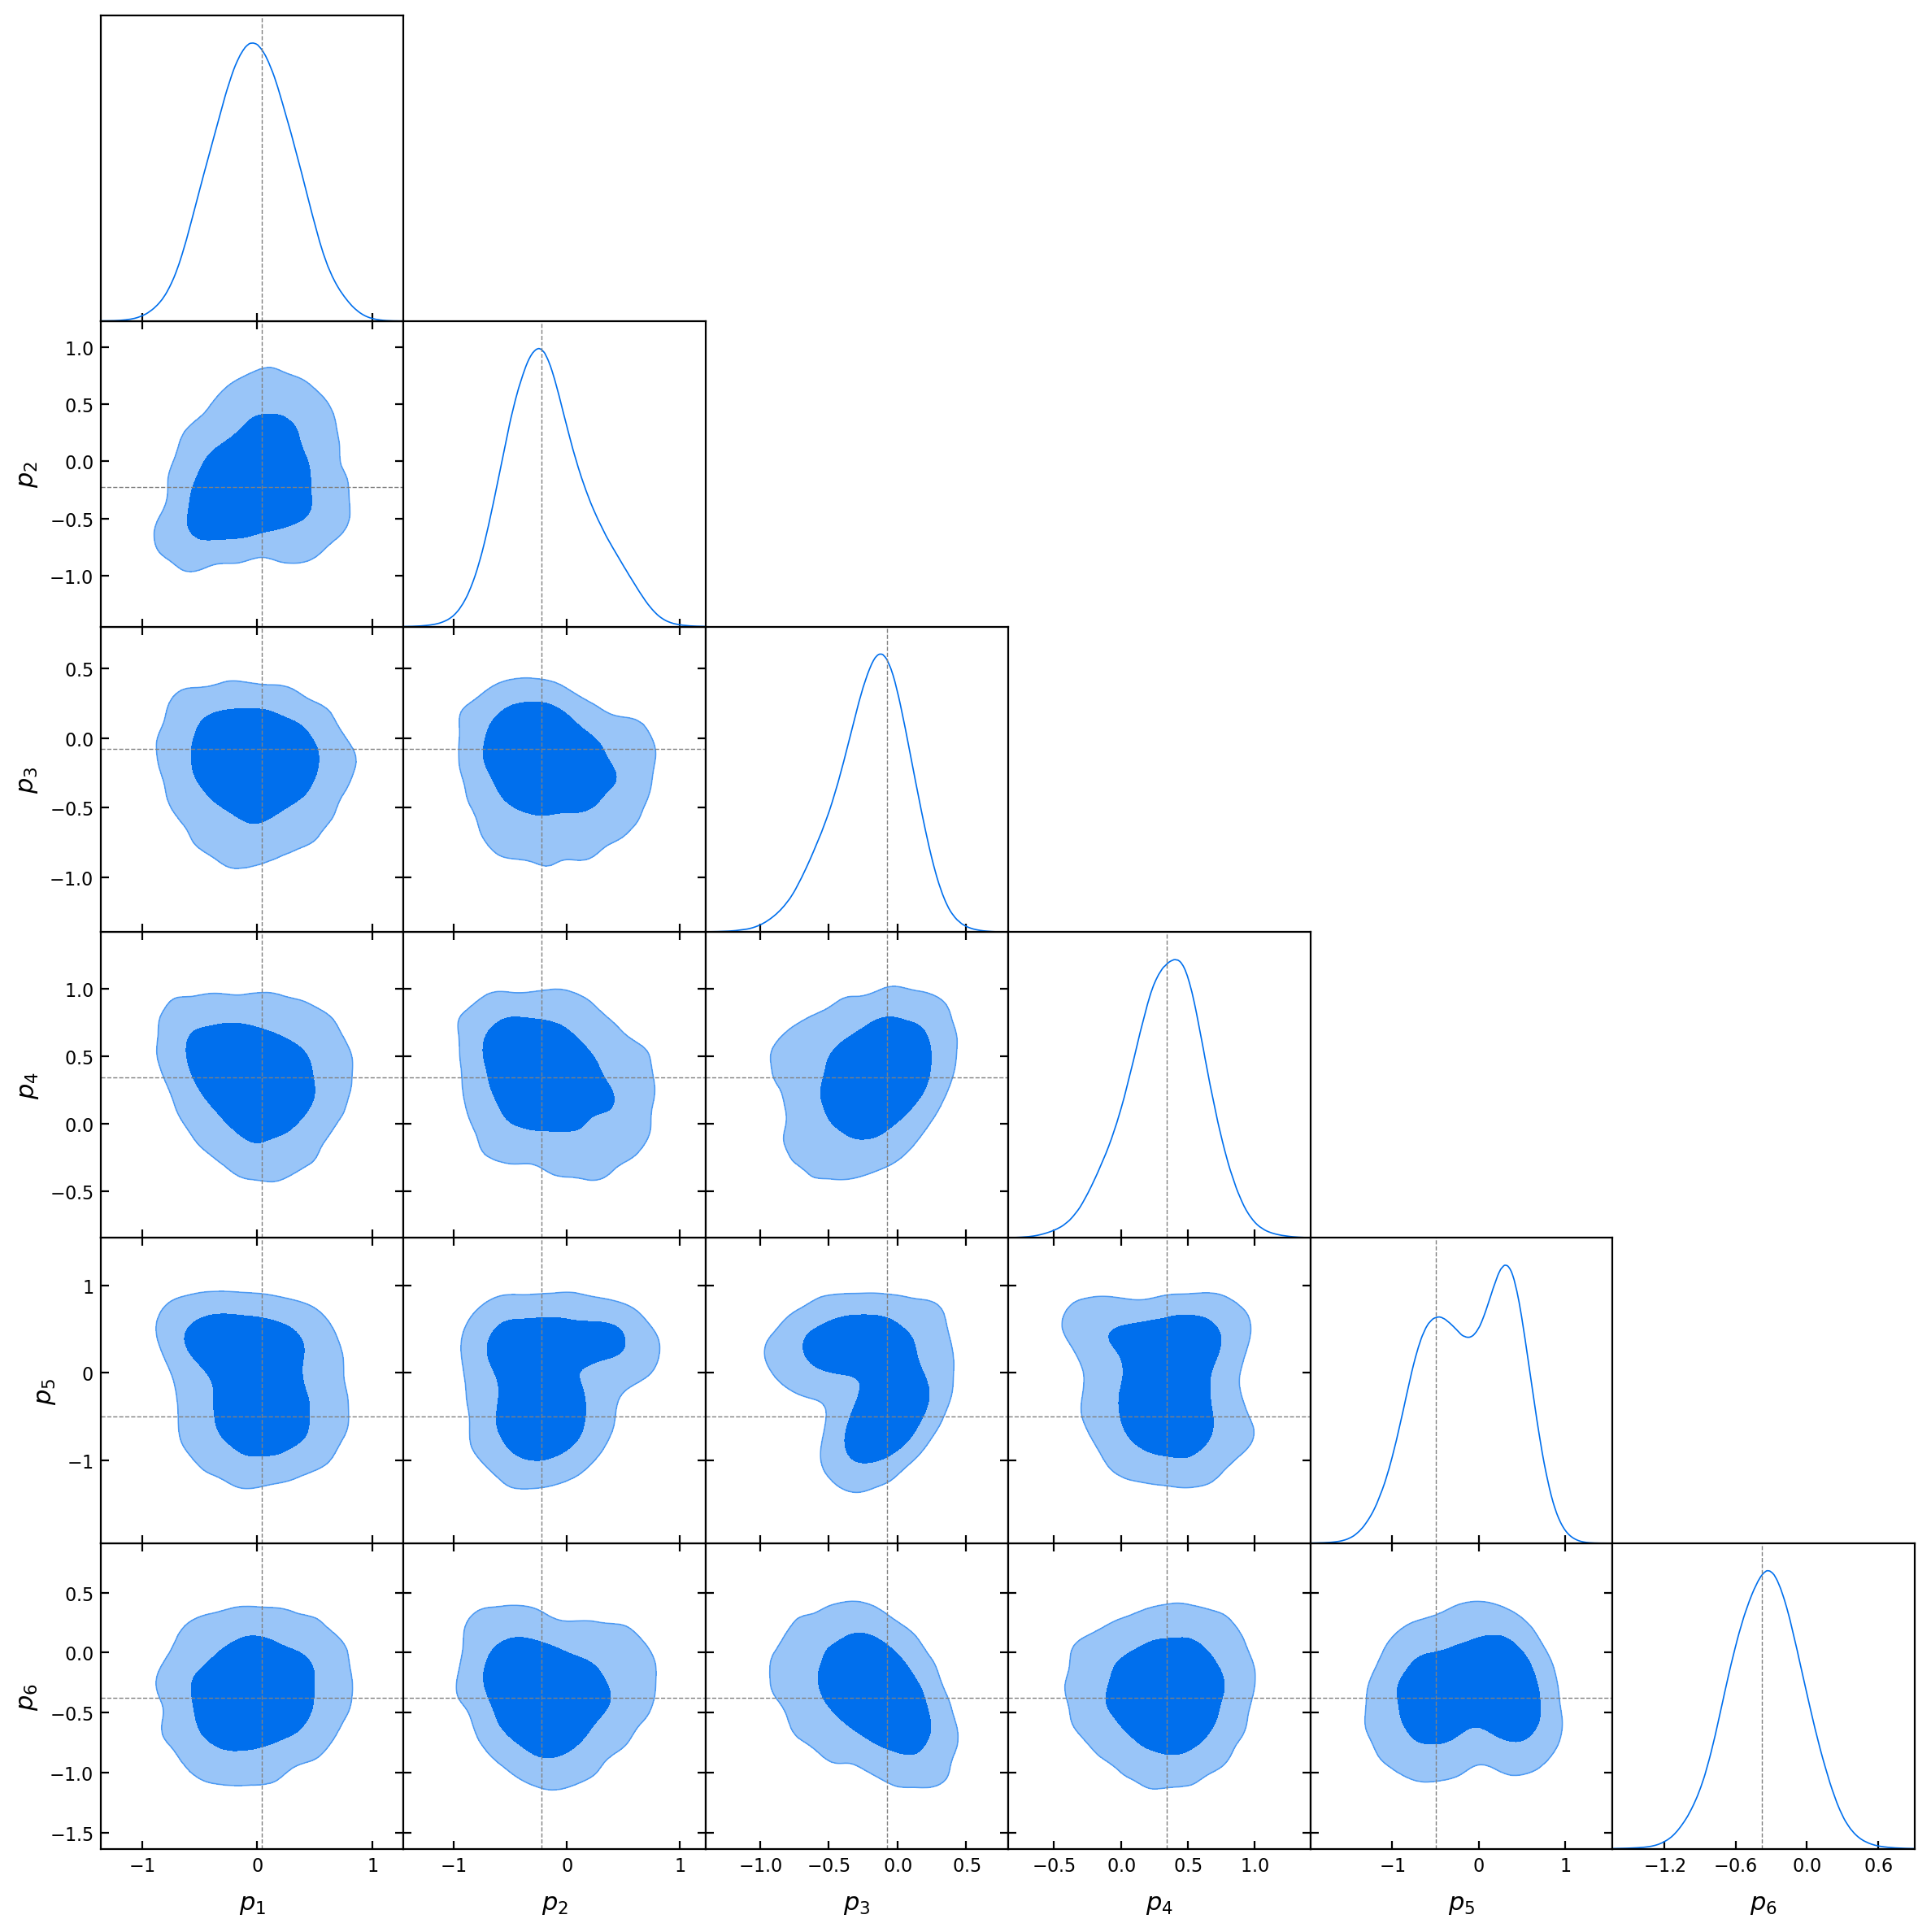

In [2]:
# define the parameters of the problem:
dim = 6
num_gaussians = 3
num_samples = 10000

# we seed the random number generator to get reproducible results:
seed = 100
np.random.seed(seed)
# we define the range for the means and covariances:
mean_range = (-0.5, 0.5)
cov_scale = 0.4**2
# generate means and covs:
means = np.random.uniform(mean_range[0], mean_range[1], num_gaussians*dim).reshape(num_gaussians, dim)
weights = np.random.rand(num_gaussians)
weights = weights / np.sum(weights)
covs = [cov_scale*utilities.vector_to_PDM(np.random.rand(int(dim*(dim+1)/2))) for _ in range(num_gaussians)]

# initialize distribution:
distribution = tfp.distributions.Mixture(
    cat=tfp.distributions.Categorical(probs=weights),
    components=[
        tfp.distributions.MultivariateNormalTriL(loc=_m, scale_tril=tf.linalg.cholesky(_c))
        for _m, _c in zip(means, covs)
    ], name='Mixture')

# sample the distribution:
samples = distribution.sample(num_samples).numpy()
# calculate log posteriors:
logP = distribution.log_prob(samples).numpy()

# create MCSamples from the samples:
chain = MCSamples(samples=samples, 
                  settings=getdist_settings,
                  loglikes=-logP,
                  name_tag='Mixture',
                  )

# we want to find the maximum posterior point:
_temp_maxima, _temp_max_value = [], []
for _m in means:
    # maximize the likelihood starting from all the means:
    _max = scipy.optimize.minimize(lambda x: -distribution.log_prob(x).numpy(), _m, method='Nelder-Mead')
    # this usually converges to the nearest mode:
    _temp_maxima.append(_max.x)
    _temp_max_value.append(-_max.fun)
maximum = _temp_maxima[np.argmax(_temp_max_value)]
maximum_value = _temp_max_value[np.argmax(_temp_max_value)]

# we make a sanity check plot:
g = plots.get_subplot_plotter()
g.triangle_plot(chain, filled=True, markers=maximum)

As we can see this example beautifully showcases projection effects, especially in $p_5$. As you might have seen in the synthetic probability notebook the low peak in the 1D marginal of $p_5$ is the actual full-D peak.

## Flow training:

We now train a synthetic probability model. Note that we need a flow with good local accuracy since we are going to maximize its value.

If you are interested in how to build and control these types of flows, check out the synthetic probability tutorial.

In [3]:
kwargs = {
          'feedback': 1,
          'verbose': -1,
          'plot_every': 1000,
          'pop_size': 1,
          'num_flows': 5,
          'epochs': 300,
        }

flow = tensiometer.synthetic_probability.average_flow_from_chain(chain,  # parameter difference chain
                                                                 **kwargs)

Training flow 0
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training flow 1
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training flow 2
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training flow 3
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training flow 4
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [4]:
# we need to check metrics to make sure everything looks good:
flow.print_training_summary()

Number of flows: 5
Flow weights   : [0.21 0.2  0.2  0.19 0.2 ]
loss         : [7.29 7.3  7.34 7.32 7.37]
val_loss     : [7.35 7.39 7.4  7.42 7.39]
lr           : [0. 0. 0. 0. 0.]
chi2Z_ks     : [0.05 0.04 0.05 0.04 0.05]
chi2Z_ks_p   : [0.02 0.08 0.02 0.04 0.01]
loss_rate    : [ 0.    0.   -0.   -0.   -0.01]
val_loss_rate: [ 0.    0.   -0.   -0.01 -0.  ]


In [5]:
# then we need to check the estimate of the local accuracy:
ev, eer = flow.evidence()
print(f'log(Z) = {ev} +- {eer}')

log(Z) = 0.08167830109596252 +- 0.531214714050293


It is usually good to check that the evidence error (if available) is under control, especially when we want to obtain posterior profiles. 

The evidence error is the variance of log likelihood values on samples from the flow and gives us a handle on the local accuracy of the flow.

Cathastrofic initialization of weights happens and if this value is too high then it might be worth re-running flow training.

If you are training on marginals (without likelihood values available) then it might be a good idea to add population selection as a layer of protection against bad initialization.

If you find that the results are not stable (especially in the bulk of the posterior) check out the notebook on synthetic probability modelling and the section discussing high accuracy flows.

## Posterior profile:

We now want to calculate posterior profiles for our distribution. These are obtained maximizing over all parameters but the ones that are been considered.

Having efficient flow models from which we can sample and calculate probability values means that we can afford lots of maximizations, so that we can calculate up to 2D profiles. 

Note that a flow can be trained on marginal distributions, allowing us to combine profiling and marginalization.

Posterior profiles can be easily obtained using the appropriate tensiometer class operating on the flow:

In [6]:
from tensiometer.synthetic_probability import flow_profiler

# define the options for the profiler:
profiler_options = {
        'num_gd_interactions_1D': 100,  # number of gradient descent interactions for the 1D profile
        'num_gd_interactions_2D': 100,  # number of gradient descent interactions for the 2D profile
        'scipy_options': {  # options for the scipy polishing minimizer
                    'ftol': 1.e-06,
                    'gtol': 0.0,
                    'maxls': 40,
                },
        'scipy_use_jac': True,  # use the jacobian in the minimizer
        'num_points_1D': 64, # number of points for the 1D profile
        'num_points_2D': 32, # number of points per dimension for the 2D profile
        'smooth_scale_1D': 0.2, # smoothing scale for the 1D profile
        'smooth_scale_2D': 0.2, # smoothing scale for the 2D profile
        }

# initialize the profiler:
flow_profile = flow_profiler.posterior_profile_plotter(flow, 
                                                       initialize_cache=False,  # usually we want to avoid initializing the cache for all the parameters
                                                       feedback=2,  # we want high feedback to see the progress
                                                )

Flow profiler
  * use_scipy  = True
  * pre_polish = True
  * polish     = True
  * smoothing  = True
  * box_prior  = False
  * parameters = ['param1', 'param2', 'param3', 'param4', 'param5', 'param6']
  * feedback   = 2


We now have initialized the profiler. If cache initialization is enabled the code will calculate 1D and 2D profiles for all parameter combinations. This is usually a lot of work so we keep it separate in this tutorial and proceed with the profile calculation for just a few parameters:

In [7]:
# now we initialize the cache for the parameters we want to profile:
profile_params = ['param3', 'param5']
flow_profile.update_cache(params=profile_params, 
                          **profiler_options)


  * initializing profiler data.
    * generating samples for profiler
    - number of random search samples = 20000
    - sampling the distribution
    - time taken to sample the distribution 23.53 (s)
  * finding MAP
    * finding global best fit
    - doing initial randomized search
    - time taken for random initial selection 0.002426 (s)
    - doing minimization (scipy)
    - time taken for minimization 10.97 (s)
  * initializing 1D profiles
    1D profiles:   0%|          | 0/2 [00:00<?, ?it/s]
    * calculating the 1D profile for: param3 with index 2
    - doing initial randomized search
    - time taken for random algorithm 0.8783 (s)
    - number of 1D bins 64
    - number of empty/filled 1D bins 4 / 60
    - doing gradient descent pre-polishing
    - time taken for gradient descents 34.51 (s)
      at the end of descent after 100 steps 1 samples were still beeing optimized.
      gradient descents did not improve 28 points
    - doing minimization polishing (scipy)
    - time

As you can notice the profile calculation is complicated and intensive. For this reason caching is implemented and thoroughly used.

After calculating profiles the result can be saved to file for effective caching:

In [8]:
# this command will save the profile to a pickle file:
#flow_profile.savePickle('flow_profile.pkl')
# note that the flow cannot be pickled easily and has its own save and load functions. This means you have to save it separately.
#flow_profile = flow_profiler.posterior_profile_plotter.loadPickle('flow_profile.pkl', flow)

The profiler class hijacks getdist MCSamples so that it can be directly used for getdist plotting as follows:

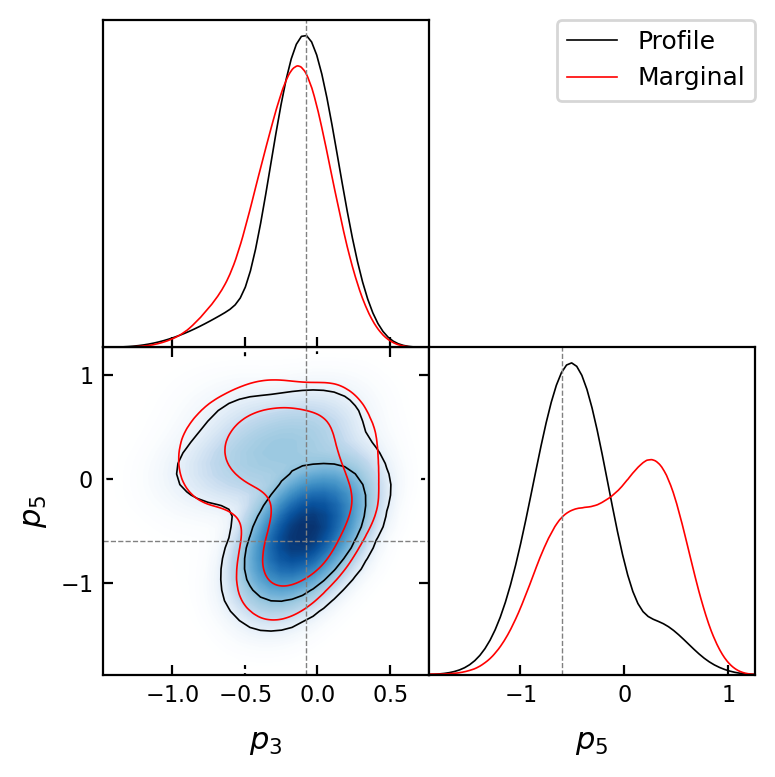

In [9]:
g = plots.get_subplot_plotter()
g.triangle_plot([flow_profile, flow.MCSamples(10000)], 
                params=profile_params,
                markers=[flow_profile.flow_MAP[flow_profile.index[_p]] for _p in profile_params],
                filled=False, 
                shaded=True, 
                diag1d_kwargs={'normalized':True},
                legend_labels=['Profile','Marginal'])

As we can see the projection effect in $p_5$ is rightfully recovered and the mode that is smaller in the marginal is much higher in the profile.

Note that there might be some little discrepancy between the peak of the profiles and the full-D peak, while there should be no difference.
This is due to the finite resolution of the 1D and 2D profiles, which are typically only computed on a small-ish grid.

The profiler class is fully interfaced with getdist plotting facilities. 
Everything that is not previously cached is recomputed on the flight, as we can see in the following example:


    * calculating the 1D profile for: param1 with index 0
    * generating samples for profiler
    - number of random search samples = 20000
    - sampling the distribution
    - time taken to sample the distribution 0.1378 (s)
    - doing initial randomized search
    - time taken for random algorithm 0.002753 (s)
    - number of 1D bins 64
    - number of empty/filled 1D bins 3 / 61
    - doing gradient descent pre-polishing
    - time taken for gradient descents 34.58 (s)
      at the end of descent after 100 steps 12 samples were still beeing optimized.
      gradient descents did not improve 45 points
    - doing minimization polishing (scipy)
    - time taken for polishing 9.276 (s)
    - doing interpolation on regular grid
    - time taken for interpolation 0.0008199 (s)
    - smoothing results
    - time taken for smoothing 0.000984 (s)


(3, 1)

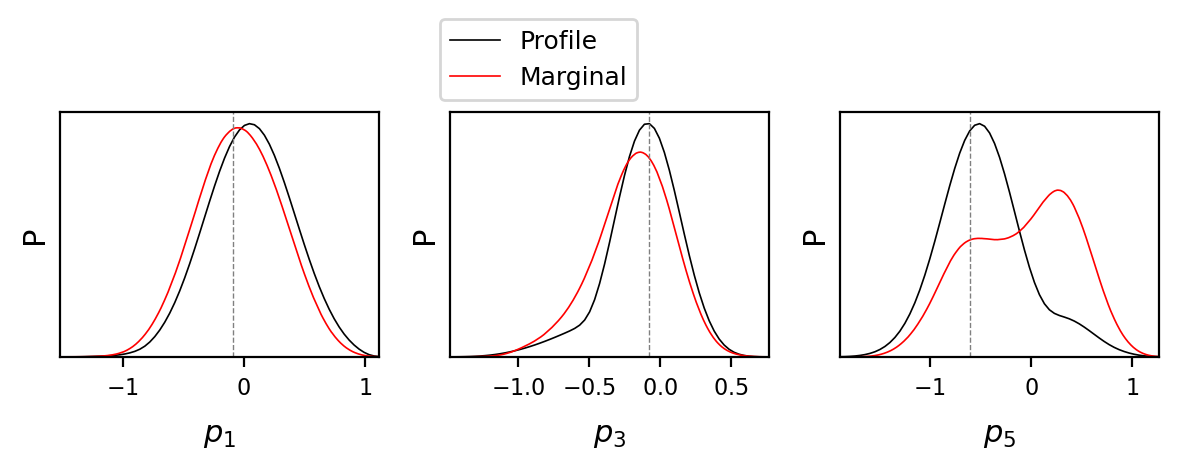

In [10]:
plot_params = ['param1'] + profile_params 
g = plots.get_subplot_plotter()
g.plots_1d([flow_profile, flow.MCSamples(10000)], 
           params=plot_params, 
           legend_labels=['Profile','Marginal'], 
           nx=3, normalized=True,
           markers=[flow_profile.flow_MAP[flow_profile.index[_p]] for _p in plot_params])


## Profile accuracy tests:

The profiler calculation is hard. As you might have seen it requires hundreds or thousands of minimization instances. 

In this section we investigate the reliability of the profile calculation. 
We can do so since - in this example - we have the exact distribution available.

We implemented methods to wrap a tensorflow or scipy distribution into a flow so that it can be used for thorough tests.

In [11]:
# In this case we can compare with the profile obtained from the exact distribution:

from tensiometer.synthetic_probability import analytic_flow

exact_flow = analytic_flow.analytic_flow(analytic_flow.tf_prob_wrapper(distribution),
                           param_names=flow.param_names, 
                           param_labels=flow.param_labels, 
                           lims=flow.parameter_ranges)
exact_profile = flow_profiler.posterior_profile_plotter(exact_flow, 
                                          initialize_cache=False,
                                          feedback=2 )
exact_profile.update_cache(params=profile_params, 
                            **profiler_options)


Flow profiler
  * use_scipy  = True
  * pre_polish = True
  * polish     = True
  * smoothing  = True
  * box_prior  = False
  * parameters = ['param1', 'param2', 'param3', 'param4', 'param5', 'param6']
  * feedback   = 2
  * initializing profiler data.
    * generating samples for profiler
    - number of random search samples = 20000
    - sampling the distribution
    - time taken to sample the distribution 0.3561 (s)
  * finding MAP
    * finding global best fit
    - doing initial randomized search
    - time taken for random initial selection 0.0004141 (s)
    - doing minimization (scipy)
    - time taken for minimization 2.085 (s)
  * initializing 1D profiles
    1D profiles:   0%|          | 0/2 [00:00<?, ?it/s]
    * calculating the 1D profile for: param3 with index 2
    - doing initial randomized search
    - time taken for random algorithm 0.004016 (s)
    - number of 1D bins 64
    - number of empty/filled 1D bins 3 / 61
    - doing gradient descent pre-polishing
    - tim

We now plot the profiles.

We log plot the 1D distributions to appreciate flow accuracy in the tails. Note that the flow is optimized on log probabilities so it is expected to do a fairly good job across orders of magnitudes in probability. On the other hand small errors in log space are big errors in probability, hence the requirement of high overall accuracy.

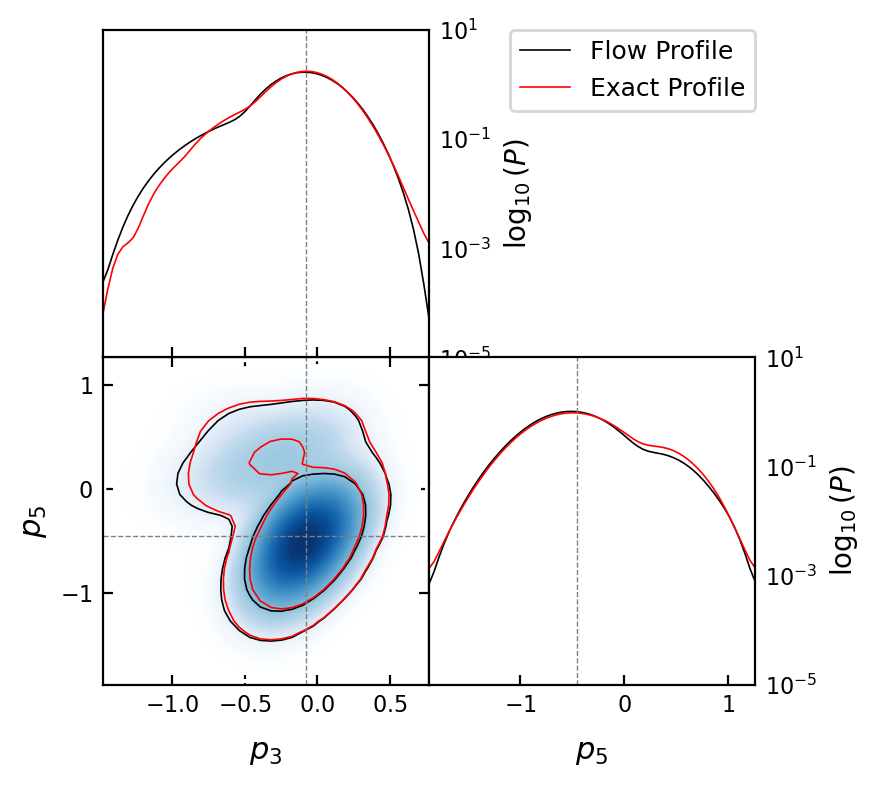

In [12]:
g = plots.get_subplot_plotter()
g.triangle_plot([flow_profile, exact_profile], 
                params=profile_params,
                filled=False, 
                shaded=True, 
                diag1d_kwargs={'normalized':True},
                markers=[exact_profile.flow_MAP[flow_profile.index[_p]] for _p in profile_params],
                legend_labels=['Flow Profile','Exact Profile'])
# log axis on the diagonal:
for _i in range(len(profile_params)):
    _ax = g.subplots[_i, _i]
    _ax.set_yscale('log')
    _ax.set_ylim(1.e-5, 1.e1)
    _ax.set_ylabel('$\\log_{10}(P)$')
    _ax.tick_params(axis='y', which='both', labelright=True)
    _ax.yaxis.set_label_position('right')

If we trained average flows we can also estimate the error on the profile as the variance of the logPs across the flows. This is what we are going to do here:

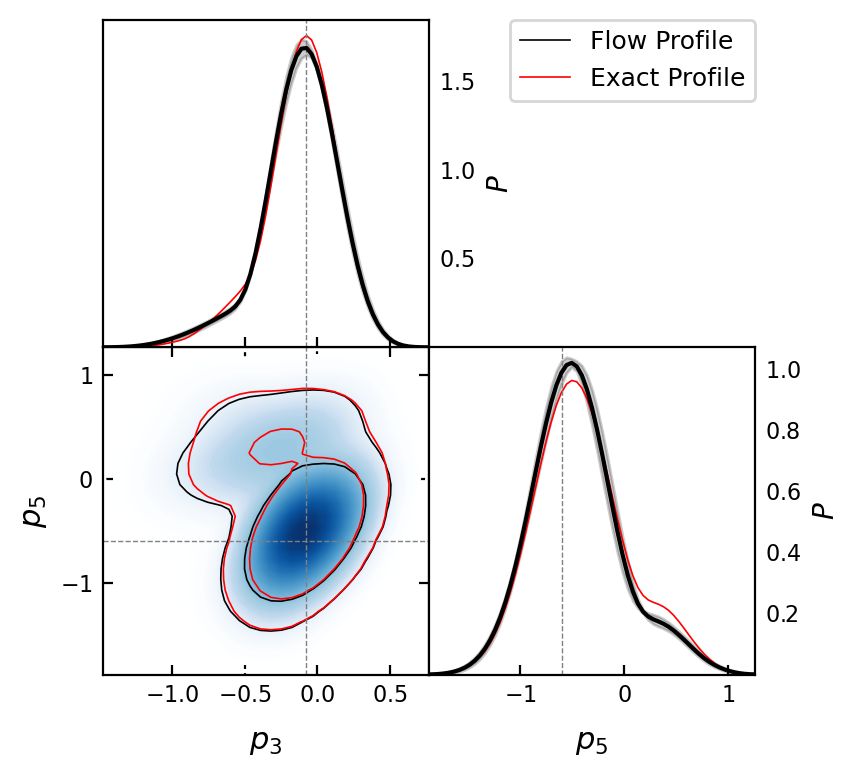

In [13]:
g = plots.get_subplot_plotter()
g.triangle_plot([flow_profile, exact_profile], params=profile_params,
                filled=False, shaded=True, diag1d_kwargs={'normalized':True},
                markers=[flow_profile.flow_MAP[flow_profile.index[_p]] for _p in profile_params],
                legend_labels=['Flow Profile','Exact Profile'])

# add error bar on the diagonal:
for _i in range(len(profile_params)):
    # call the method that computes the variance of the profile for an average flow:
    _x, _prob, _temp_std = flow_profile.get_1d_profile_variance(profile_params[_i])
    # do the plotting:
    _ax = g.subplots[_i, _i]
    _ax.plot(_x, _prob, color='k', linestyle='-', label='True')
    _ax.fill_between(_x, _prob - _temp_std, _prob + _temp_std, color='k', alpha=0.2)
    _ax.set_ylabel('$P$')
    _ax.tick_params(axis='y', which='both', labelright=True)
    _ax.yaxis.set_label_position('right')    

## Real world application: cosmological parameter profiles

In this section we show a real example of a profile applied to cosmological parameter posteriors.

In this case it is particularly interesting to combine profiling and marginalization. The full parameter space of the model is large - of order 30D - but most of these parameters describe systematic effects. These can be marginalized over, after all we might not really be interested in what happens with them and then we can profile cosmological parameters.  

Training flow 0
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training flow 1
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training flow 2
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training flow 3
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Training flow 4
* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

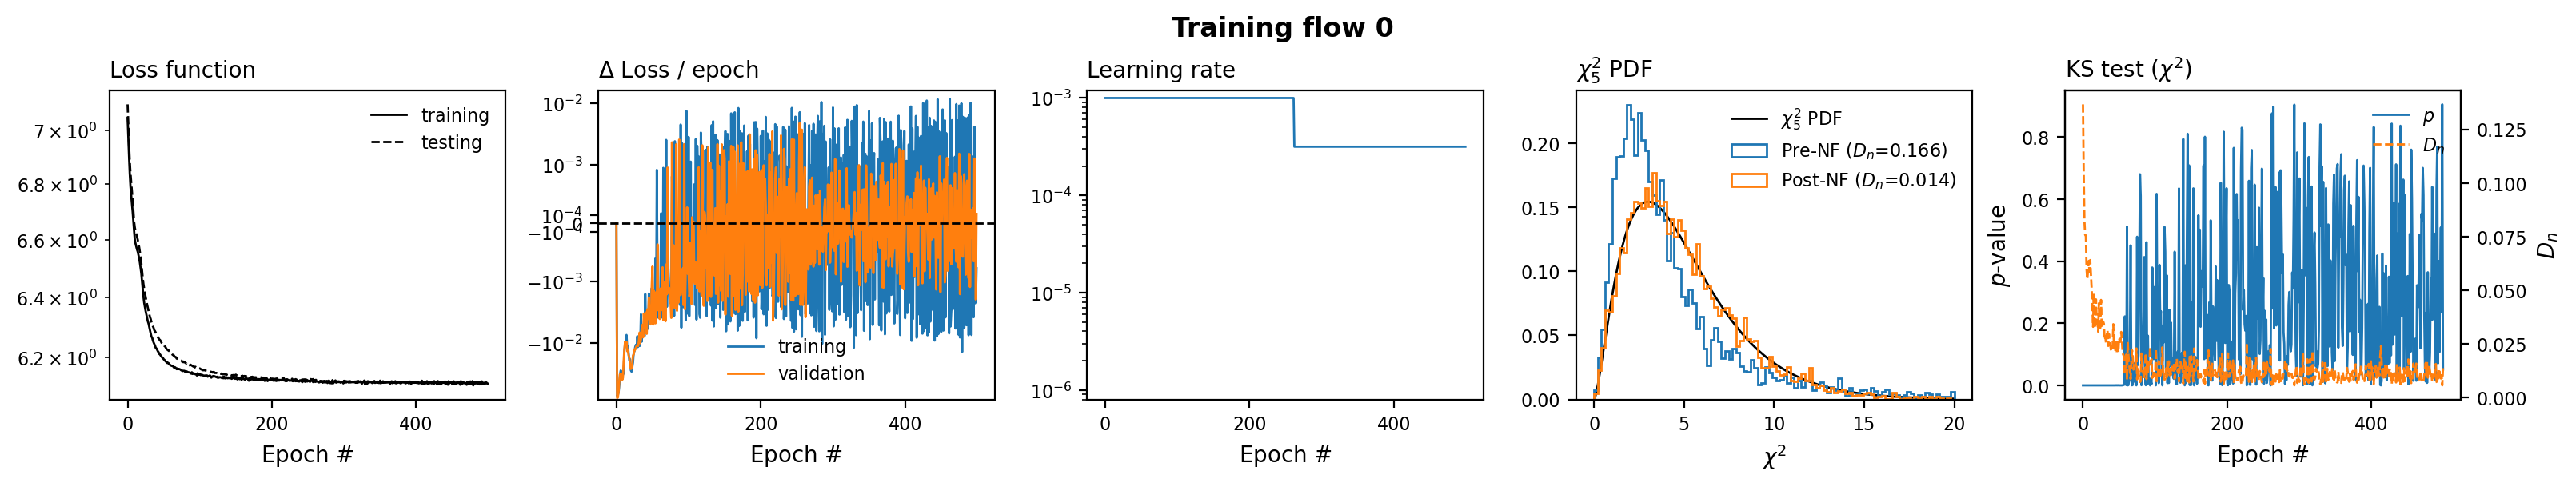

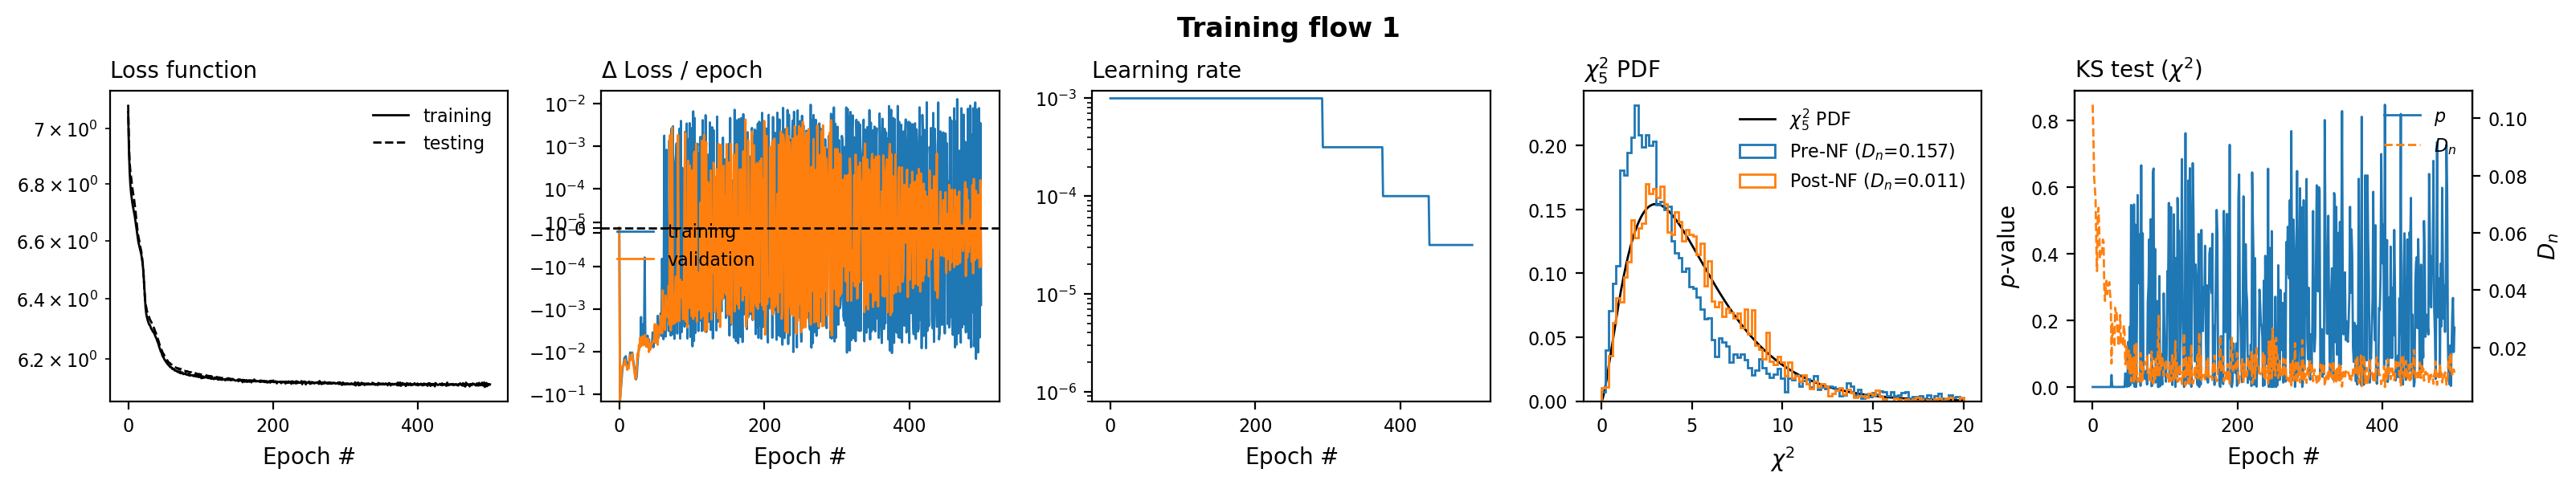

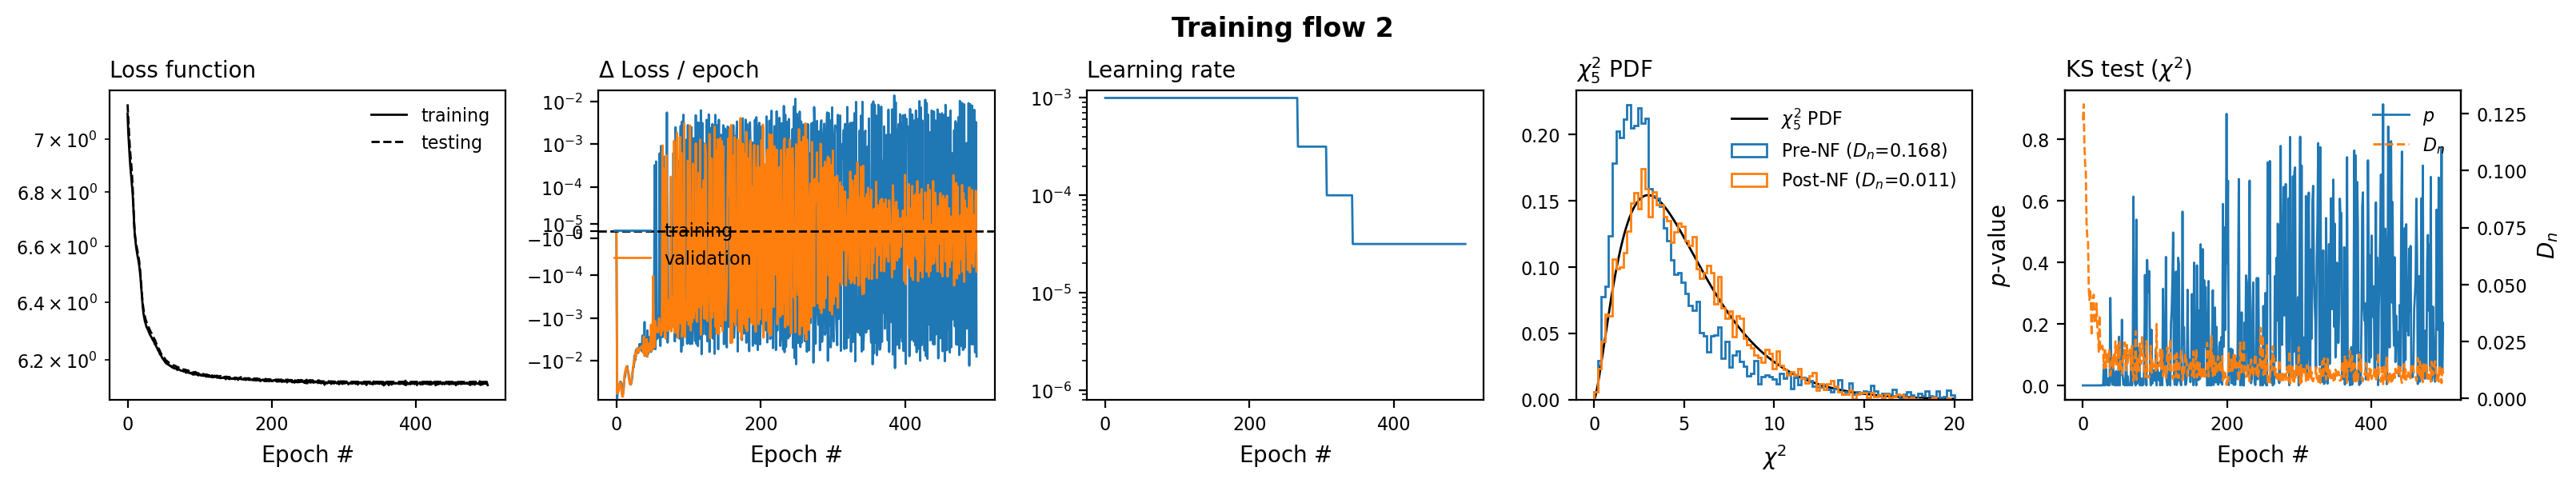

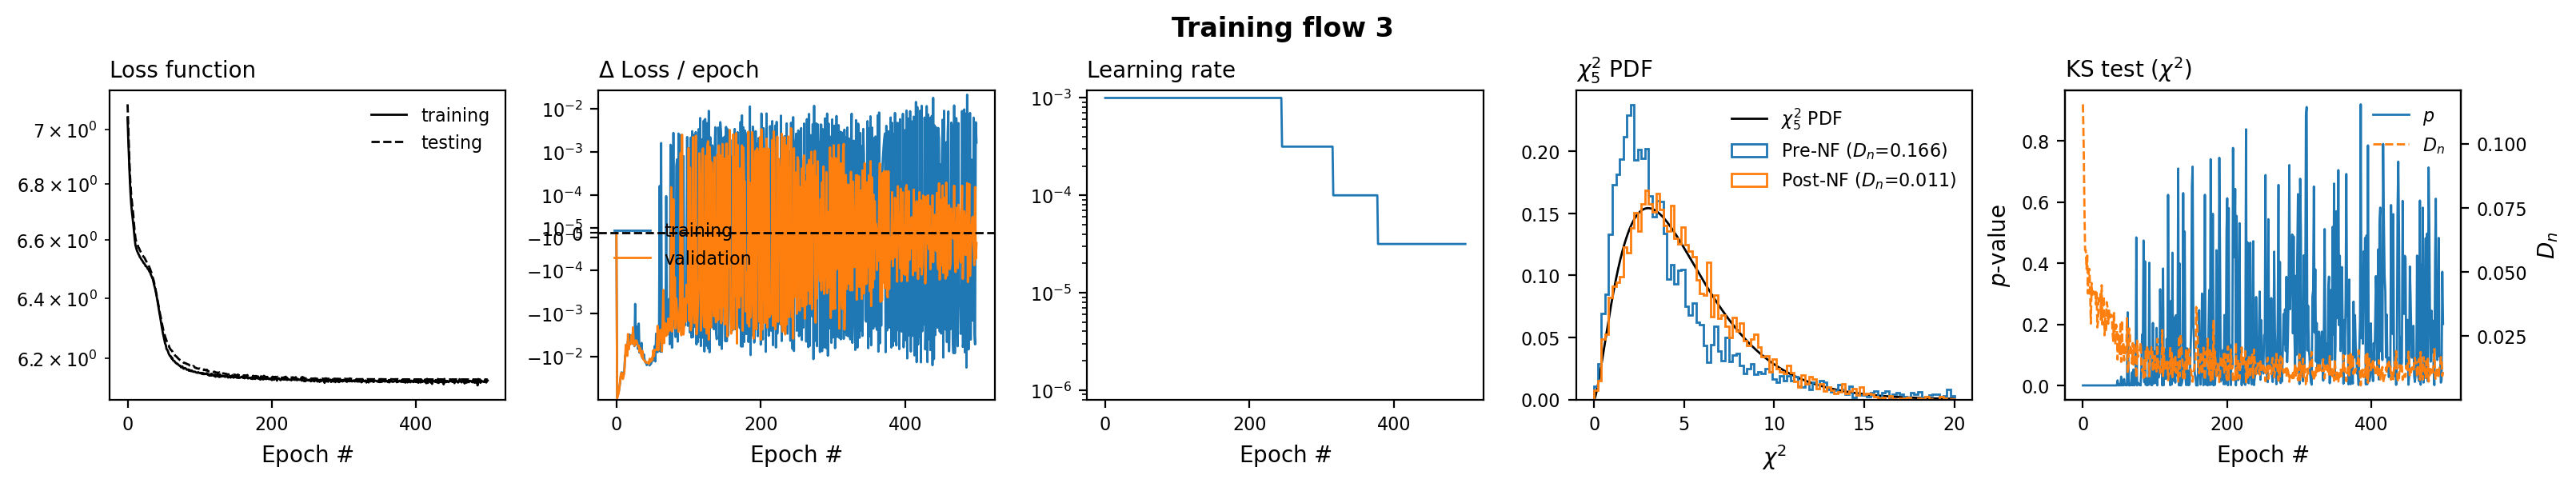

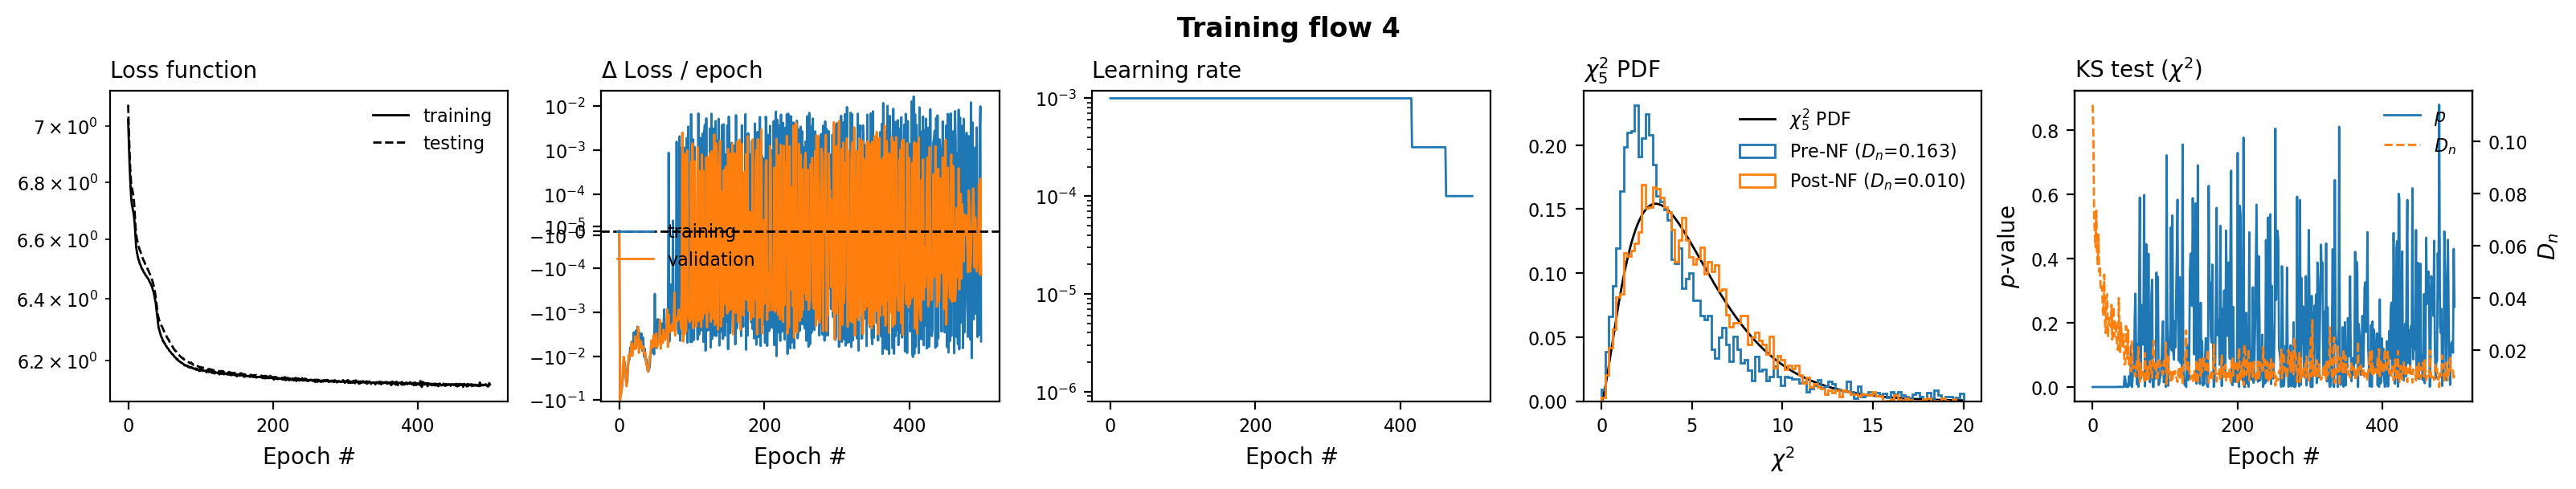

In [14]:
# we start by loading up the posterior:

# load the samples (remove no burn in since the example chains have already been cleaned):
chains_dir = './../../test_chains/'
# the DES Y1 3x2 chain:
data_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True, settings=getdist_settings)

# let's add omegab as a derived parameter:
for _ch in [data_chain]:
    _p = _ch.getParams()
    _h = _p.H0 / 100.
    _ch.addDerived(_p.omegabh2 / _h**2, name='omegab', label='\\Omega_b')
    _ch.updateBaseStatistics()

# we define the parameters of the problem:
param_names = ['H0', 'omegam', 'sigma8', 'ns', 'omegab']

# we then train the flows on the base parameters that we want to use:
kwargs = {
          'feedback': 1,
          'verbose': -1,
          'plot_every': 1000,
          'pop_size': 1,
          'num_flows': 5,
          'epochs': 500,
        }

# actual flow training:
data_flow = tensiometer.synthetic_probability.average_flow_from_chain(data_chain, param_names=param_names, **kwargs)

# plot to make sure training went well:
data_flow.training_plot()

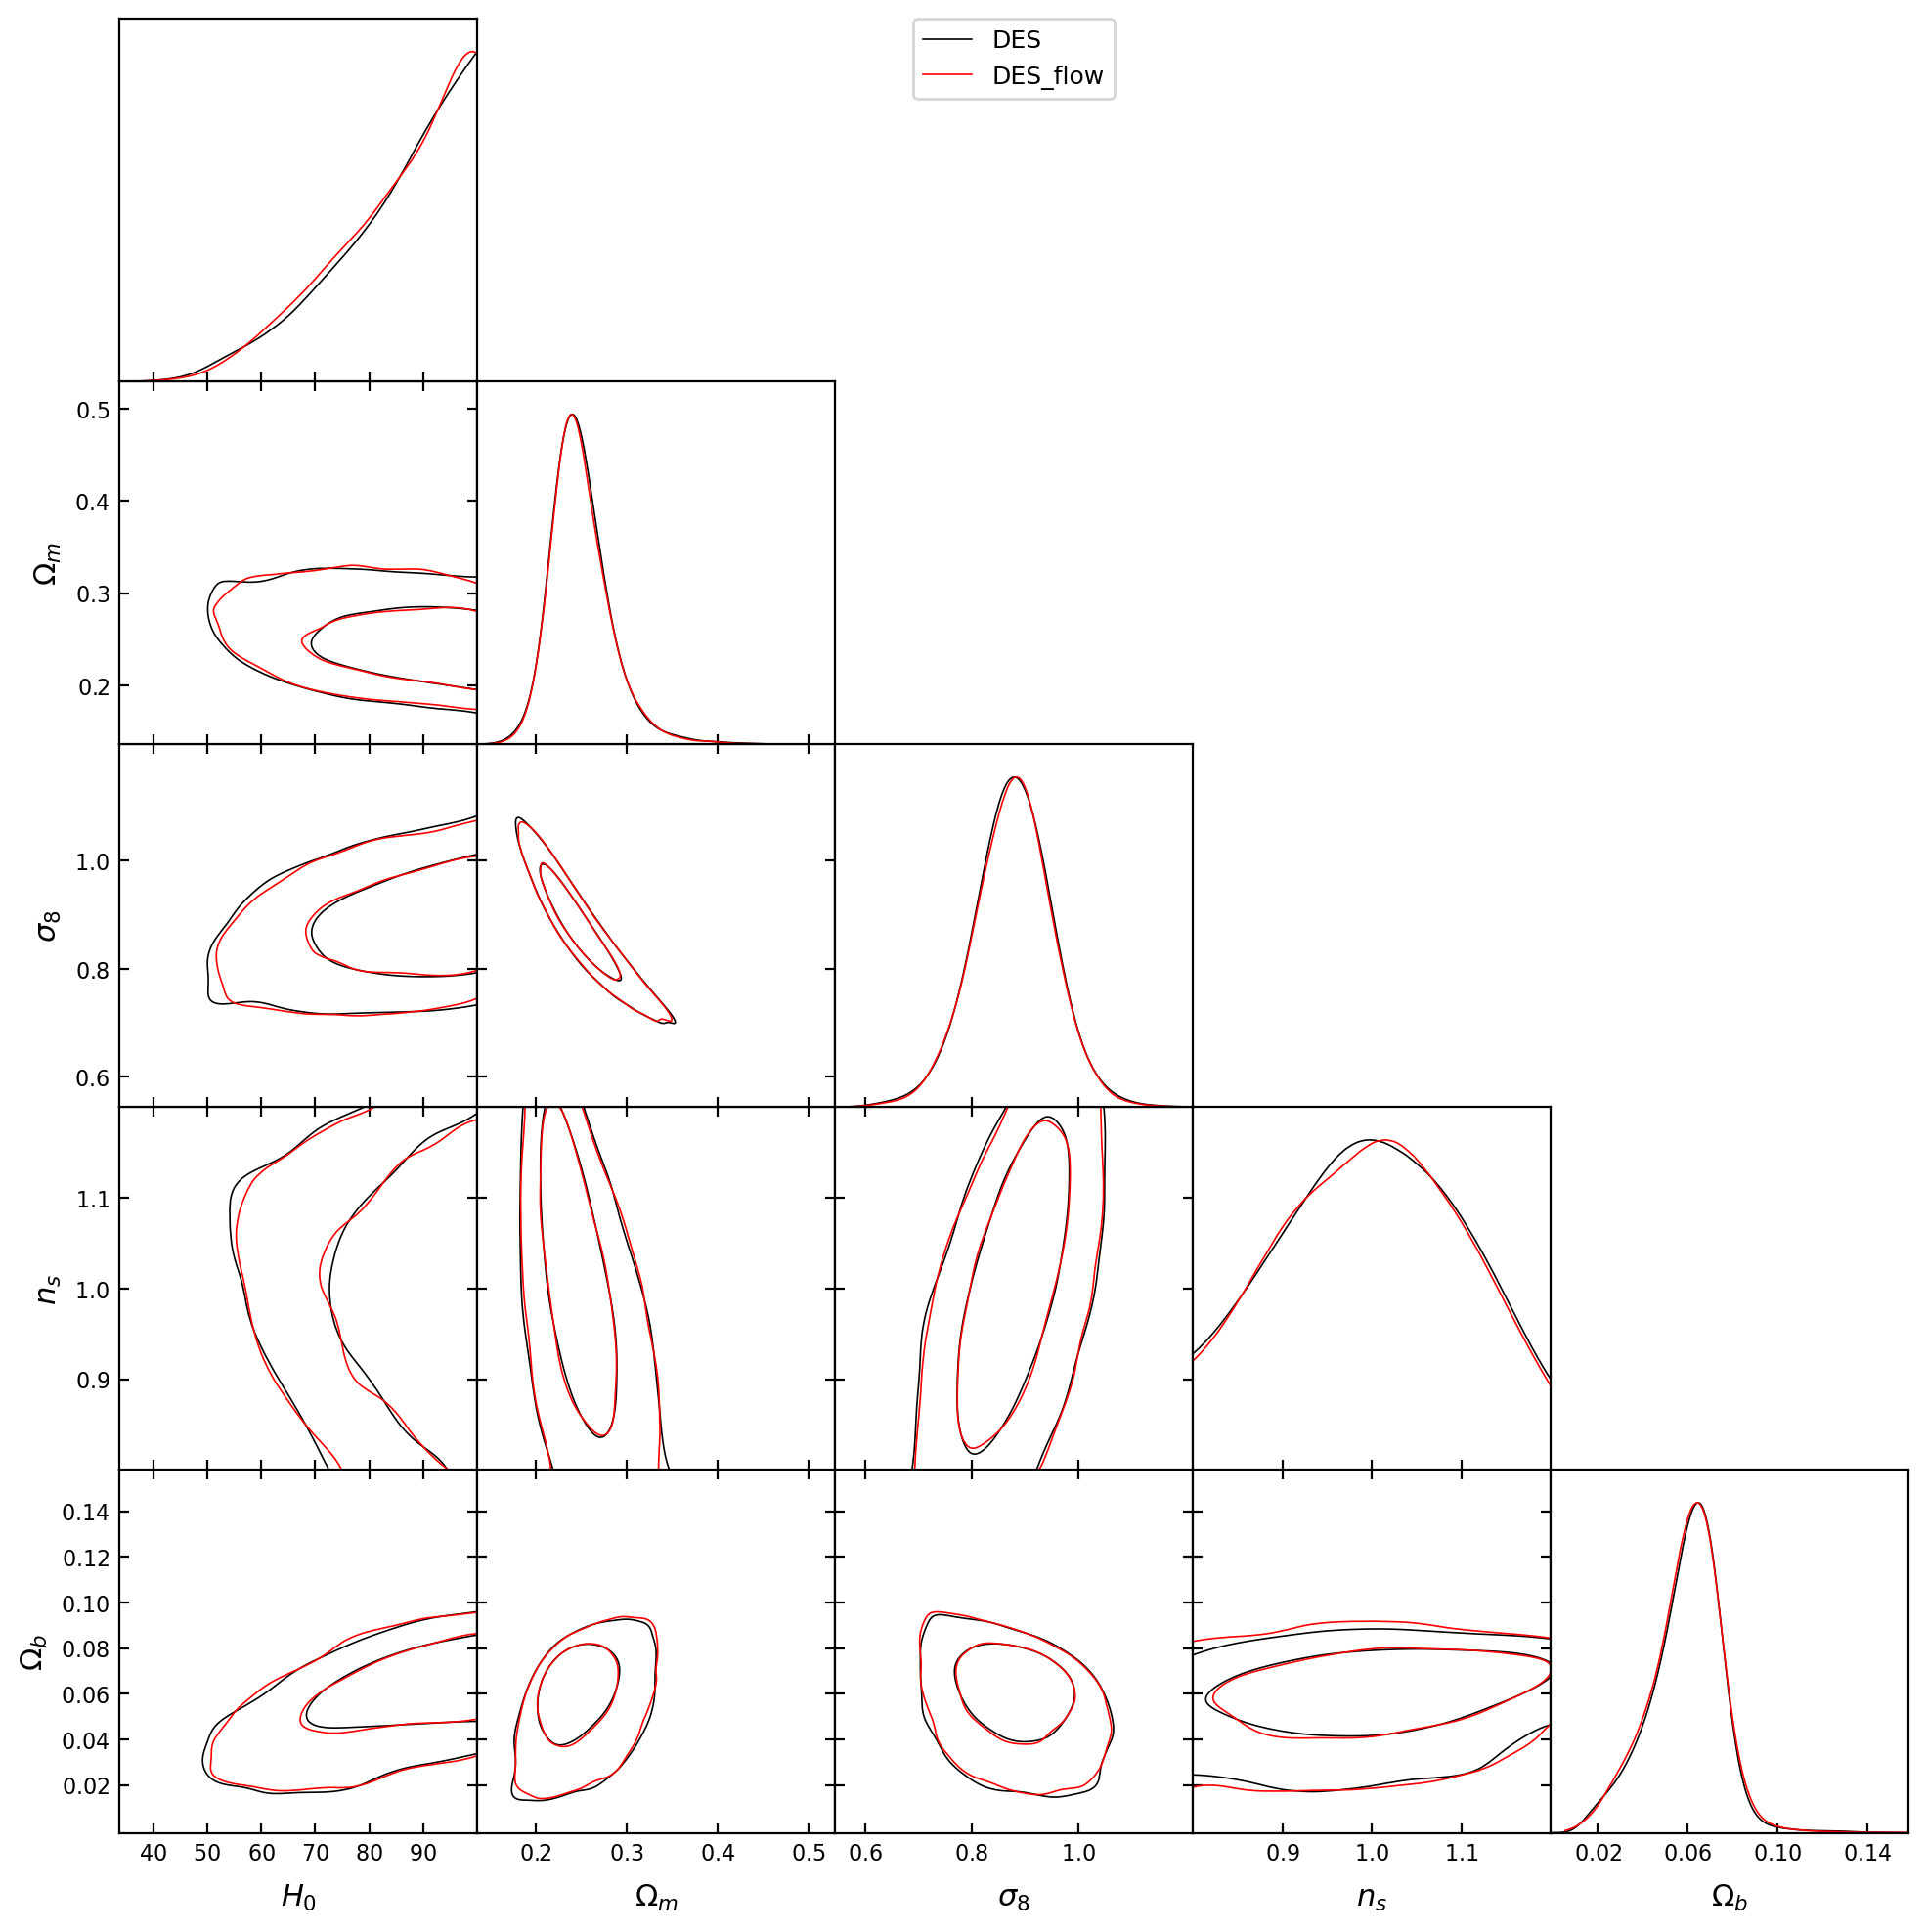

In [15]:
# sanity check triangle plot:
g = plots.get_subplot_plotter()
g.triangle_plot([data_chain, data_flow.MCSamples(20000, settings=getdist_settings),
                 ], 
                params=param_names,
                filled=False)

In [16]:
# define the options for the profiler:
profiler_options = {
        'num_gd_interactions_1D': 100,  # number of gradient descent interactions for the 1D profile
        'num_gd_interactions_2D': 100,  # number of gradient descent interactions for the 2D profile
        'scipy_options': {  # options for the polishing minimizer
                    'ftol': 1.e-06,
                    'gtol': 0.0,
                    'maxls': 100,
                },
        'scipy_use_jac': True,  # use the jacobian in the minimizer
        'num_points_1D': 64, # number of points for the 1D profile
        'num_points_2D': 32, # number of points per dimension for the 2D profile
        'smooth_scale_1D': 0.2, # smoothing scale for the 1D profile
        'smooth_scale_2D': 0.2, # smoothing scale for the 2D profile
        }

# initialize the profiler:
data_flow_profile = flow_profiler.posterior_profile_plotter(data_flow, 
                                                            initialize_cache=False,  # usually we want to avoid initializing the cache for all the parameters
                                                            feedback=2,  # we want high feedback to see the progress
                                                            )

Flow profiler
  * use_scipy  = True
  * pre_polish = True
  * polish     = True
  * smoothing  = True
  * box_prior  = False
  * parameters = ['H0', 'omegam', 'sigma8', 'ns', 'omegab']
  * feedback   = 2


In [17]:
# now we initialize the cache for the parameters we want to profile:
profile_params = ['omegam', 'sigma8', 'ns']
data_flow_profile.update_cache(params=profile_params, 
                               **profiler_options)

  * initializing profiler data.
    * generating samples for profiler
    - number of random search samples = 20000
    - sampling the distribution
    - time taken to sample the distribution 0.09842 (s)
  * finding MAP
    * finding global best fit
    - doing initial randomized search
    - time taken for random initial selection 0.0005 (s)
    - doing minimization (scipy)
    - time taken for minimization 19.57 (s)
  * initializing 1D profiles
    1D profiles:   0%|          | 0/3 [00:00<?, ?it/s]
    * calculating the 1D profile for: omegam with index 1
    - doing initial randomized search
    - time taken for random algorithm 0.008639 (s)
    - number of 1D bins 64
    - number of empty/filled 1D bins 11 / 53
    - doing gradient descent pre-polishing
    - time taken for gradient descents 30.78 (s)
      at the end of descent after 100 steps 46 samples were still beeing optimized.
      gradient descents did not improve 6 points
    - doing minimization polishing (scipy)
      W

We can now plot the profiles.

Note that - in this case - since we have no evidence estimate available it is crucial to train a bunch of flows to get an estimate of the variance of the profile.
If the variance is large it is usually a good idea to retrain...

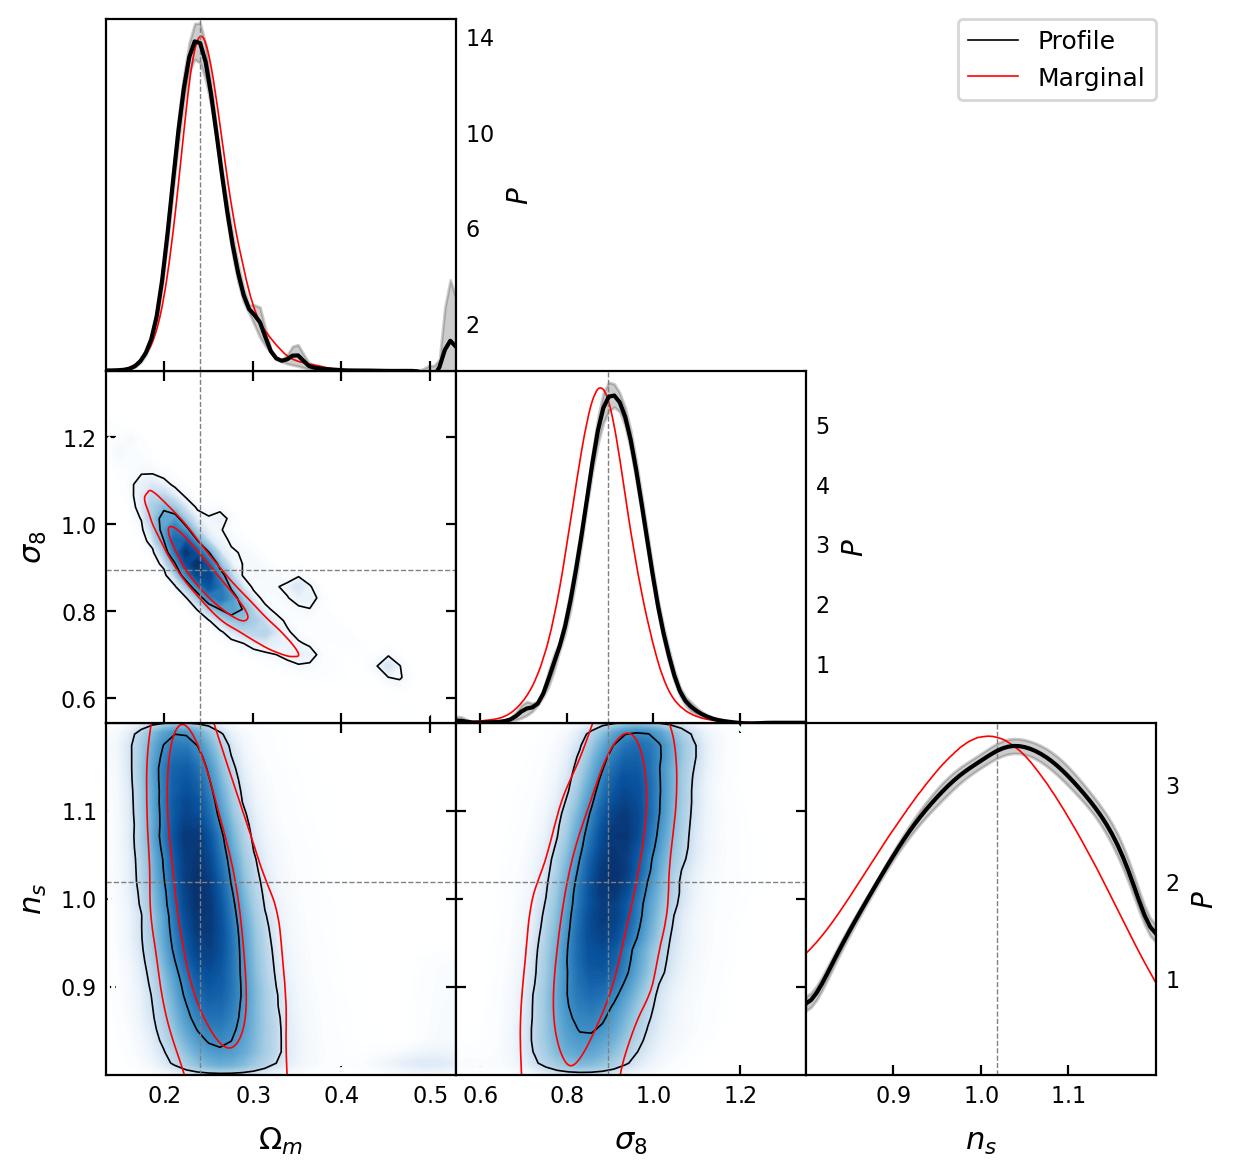

In [18]:
g = plots.get_subplot_plotter()
g.triangle_plot([data_flow_profile, data_flow.MCSamples(10000)], params=profile_params,
                filled=False, shaded=True, diag1d_kwargs={'normalized':True},
                markers=[data_flow_profile.flow_MAP[data_flow_profile.index[_p]] for _p in profile_params],
                legend_labels=['Profile','Marginal'])

# add error bar on the diagonal:
for _i in range(len(profile_params)):
    _x, _prob, _temp_std = data_flow_profile.get_1d_profile_variance(profile_params[_i])
    # do the plotting:
    _ax = g.subplots[_i, _i]
    _ax.plot(_x, _prob, color='k', linestyle='-', label='True')
    _ax.fill_between(_x, _prob - _temp_std, _prob + _temp_std, color='k', alpha=0.2)
    _ax.set_ylabel('$P$')
    _ax.tick_params(axis='y', which='both', labelright=True)
    _ax.yaxis.set_label_position('right')    


2D profiles are pretty expensive, 1D profiles, on the other hand, are fairly fast, to the point that we can compute them all for this example:

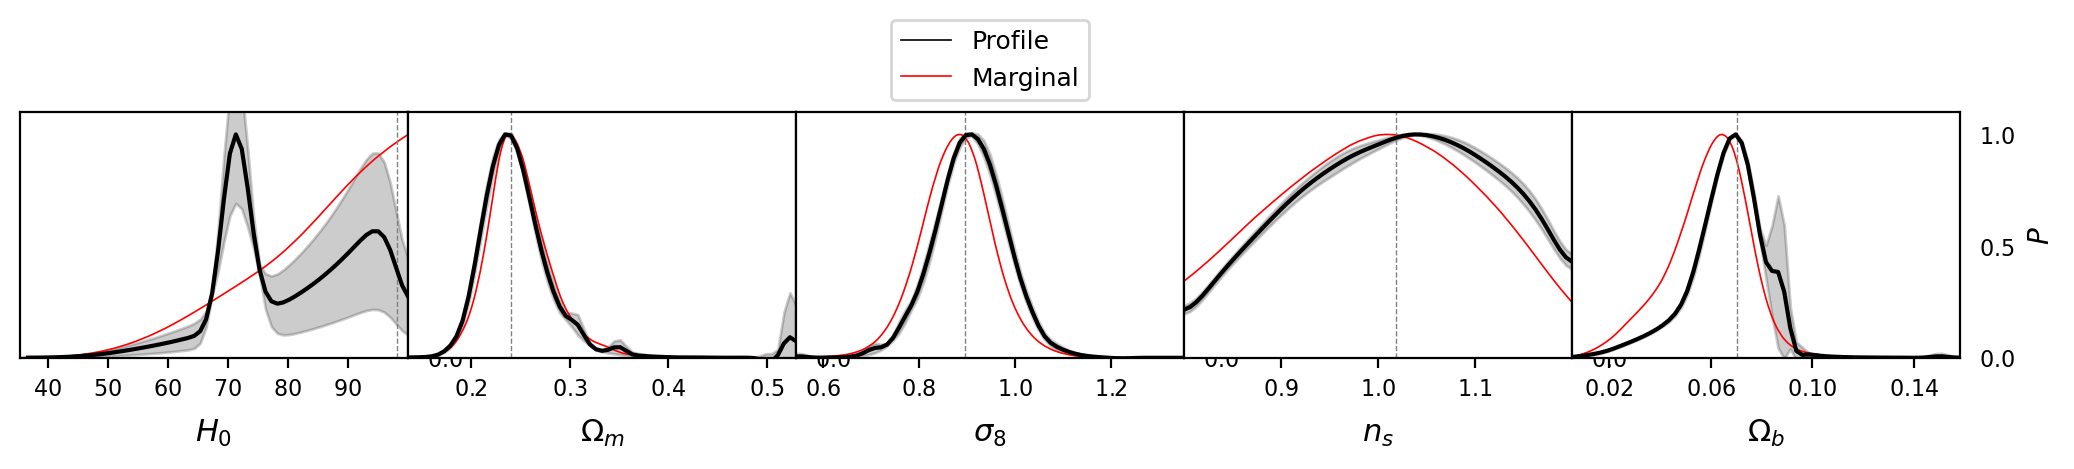

In [30]:
g = plots.get_subplot_plotter()
data_flow_profile.normalize()
g.plots_1d([data_flow_profile, data_flow.MCSamples(10000)], 
           params=param_names, 
           legend_labels=['Profile','Marginal'],
           markers=[data_flow_profile.flow_MAP[data_flow_profile.index[_p]] for _p in param_names], 
           nx=5, share_y=True, normalize=False)

# add error bars:
for _i in range(len(param_names)):
    _x, _prob, _temp_std = data_flow_profile.get_1d_profile_variance(param_names[_i], normalize_by='max')
    # do the plotting:
    _ax = g.subplots.flatten()[_i]
    _ax.plot(_x, _prob, color='k', linestyle='-', label='True')
    _ax.fill_between(_x, _prob - _temp_std, _prob + _temp_std, color='k', alpha=0.2)
    _ax.set_ylabel('$P$')
    _ax.tick_params(axis='y', which='both', labelright=True)
    _ax.yaxis.set_label_position('right')

If we compute all 1D profiles we can get best-fit and error bars from the profile likelihood (posterior really) ratios.
These are defined from posterior thresholds from the maximum.

To do so we have hijacked getdist method getLikeStats.

In [24]:
likestats = data_flow_profile.getLikeStats()
print(likestats)

Best fit sample -log(Like) = -8.482888
Ln(mean 1/like) = -2.289306
mean(-Ln(like)) = 5.683450
-Ln(mean like)  = 10.426897

parameter   bestfit        lower1         upper1         lower2         upper2
H0          9.8210068E+01  6.7385115E+01  9.8023340E+01  4.9595178E+01  1.0000000E+02   H_0
omegam      2.4083309E-01  1.9742227E-01  2.7733716E-01  1.6668578E-01  5.1093450E-01   \Omega_m
sigma8      8.9533216E-01  7.9663249E-01  9.9866977E-01  6.8298653E-01  1.1123157E+00   \sigma_8
ns          1.0186636E+00  8.3125000E-01  1.2000000E+00  8.0000000E-01  1.2000000E+00   n_s
omegab      7.0358203E-02  5.0739615E-02  8.6515426E-02  1.4963804E-02  9.3670588E-02   \Omega_b



These can be compared to the original margestats. Note that these are obtained starting from the original chain that was fed to the flow:

In [25]:
margestats = data_flow.MCSamples(10000).getMargeStats()
print(margestats)

Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
H0          8.4304194E+01  1.2190173E+01  8.0222687E+01  1.0000000E+02  <      6.0714005E+01  1.0000000E+02  <      5.1074818E+01  1.0000000E+02  <       H_0
omegam      2.4994235E-01  3.4739507E-02  2.1407751E-01  2.7352189E-01  two    1.8585565E-01  3.1954224E-01  two    1.7579925E-01  3.8904411E-01  two     \Omega_m
sigma8      8.7828869E-01  7.6690455E-02  8.0592614E-01  9.5054156E-01  two    7.2139442E-01  1.0285699E+00  two    6.5352082E-01  1.0867279E+00  two     \sigma_8
ns          9.9875168E-01  9.7997817E-02  8.9467397E-01  1.1121039E+00  two    8.0000000E-01  1.2000000E+00  none   8.0000000E-01  1.2000000E+00  none    n_s
omegab      5.9042430E-02  1.6093695E-02  4.6898330E-02  7.6640824E-02  two    2.3668360E-02  8.6705744E-02  two    1.4727294E-02  1.0232525E-01  two     \Omega_b



Let's use them to visualize constraints:

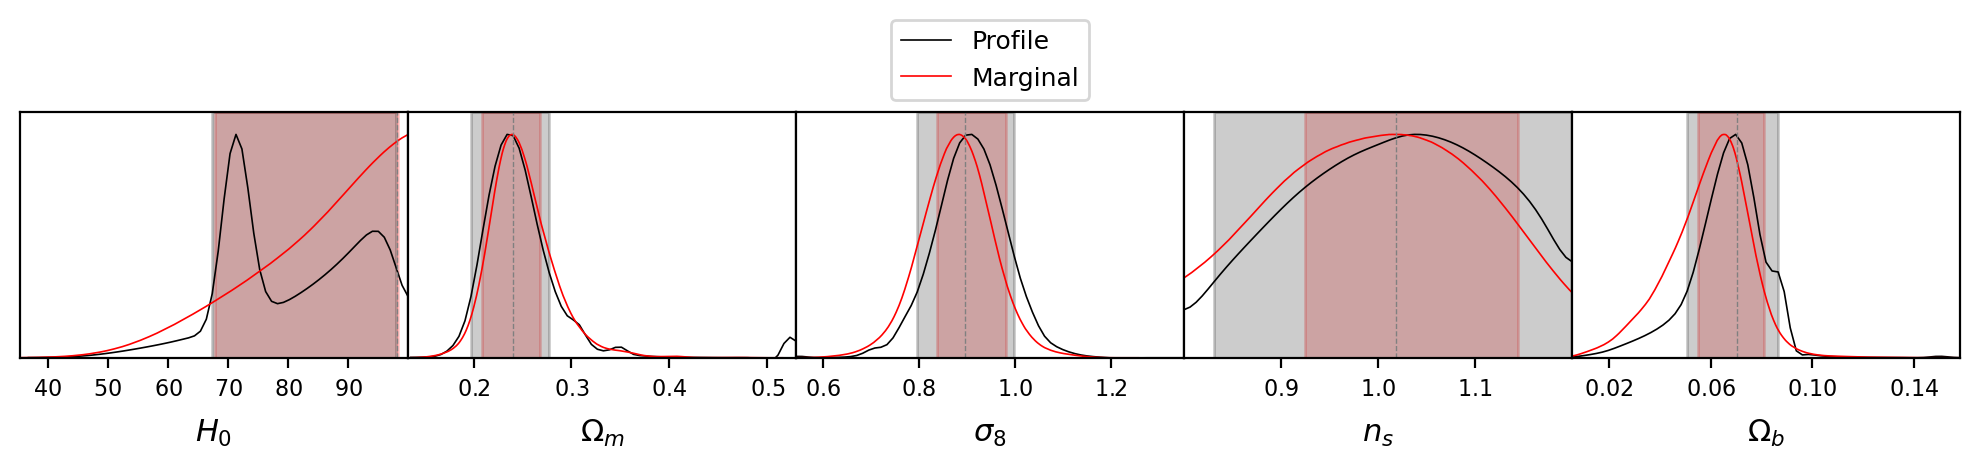

In [31]:
g = plots.get_subplot_plotter()
data_flow_profile.normalize()
g.plots_1d([data_flow_profile, data_flow.MCSamples(10000)], 
           params=param_names, legend_labels=['Profile','Marginal'],
           markers=[data_flow_profile.flow_MAP[data_flow_profile.index[_p]] for _p in param_names], 
           nx=5, share_y=True, normalize=False)

# add error bars:
for _i in range(len(param_names)):
    _ax = g.subplots.flatten()[_i]
    _marge = margestats.parWithName(param_names[_i])
    _like = likestats.parWithName(param_names[_i])
    _ax.axvspan(_marge.limits[0].lower, _marge.limits[0].upper, color='r', alpha=0.2)
    _ax.axvspan(_like.ND_limit_bot[0], _like.ND_limit_top[0], color='k', alpha=0.2)

Note that - in this example - confidence intervals obtained from the profile are more conservative than those obained with marginalized statistics.

Having hijacked getdist MCSamples, if we query for MargeStats the profiler we will get confidence intervals calculated with a given mass threshold (i.e. that the isocontour should integrate to a fraction of total).

Let's compare the two:

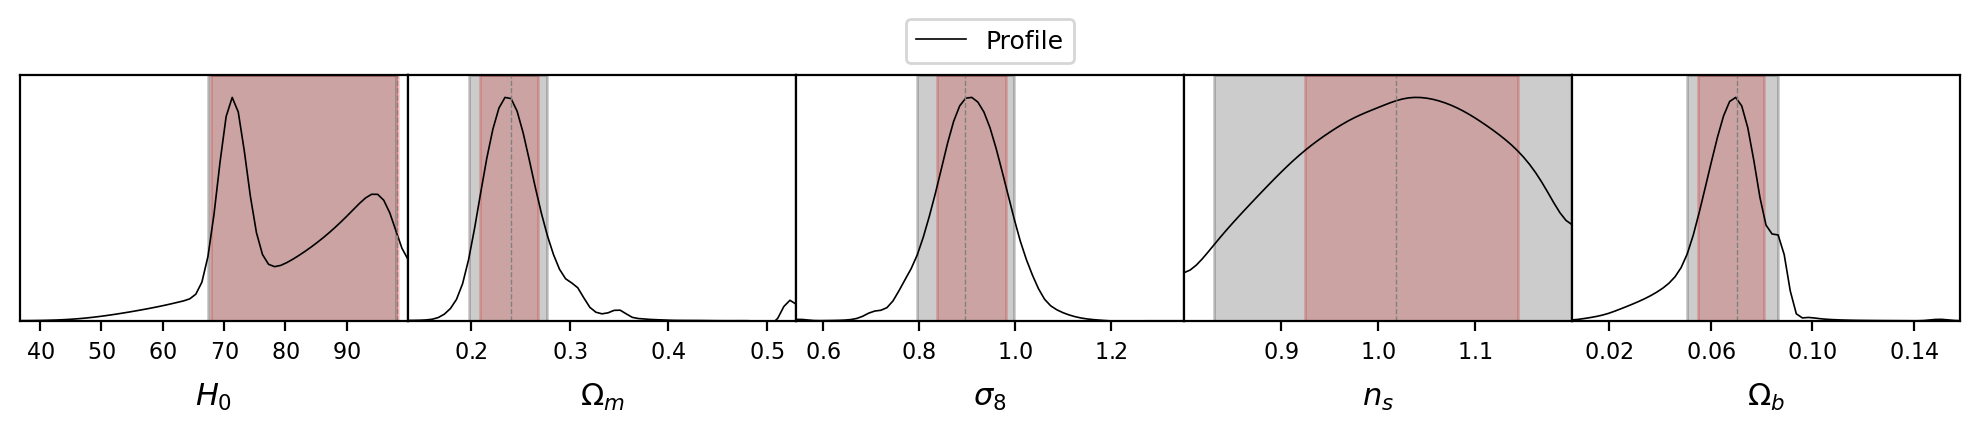

In [32]:
likestats = data_flow_profile.getLikeStats()
margestats = data_flow_profile.getMargeStats()

g = plots.get_subplot_plotter()
data_flow_profile.normalize()
g.plots_1d([data_flow_profile], 
           params=param_names, legend_labels=['Profile'],
           markers=[data_flow_profile.flow_MAP[data_flow_profile.index[_p]] for _p in param_names], 
           nx=5, share_y=True, normalize=False)

# add error bars:
for _i in range(len(param_names)):
    _ax = g.subplots.flatten()[_i]
    _marge = margestats.parWithName(param_names[_i])
    _like = likestats.parWithName(param_names[_i])
    _ax.axvspan(_marge.limits[0].lower, _marge.limits[0].upper, color='r', alpha=0.2)
    _ax.axvspan(_like.ND_limit_bot[0], _like.ND_limit_top[0], color='k', alpha=0.2)

As we can see the likelihood threshold is still more conservative. Note that this is a sign of a non-Gaussian distribution and specific to this case.